In [1]:
import pandas as pd
import numpy as np
import cv2
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn import preprocessing


/Users/alpha/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


# Stereo Image Depth Map
### Trying this method first, doesn't work as well as 2 CSVs

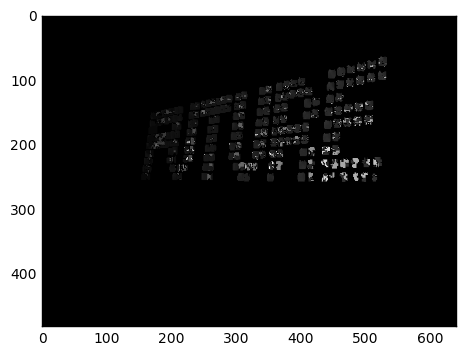

In [2]:
# Use CV Stereo depth mapping
# Input -> 2 regular images (Left, Right)
imgL = cv2.imread('future_binary_eye_dist_L.png',0)
imgR = cv2.imread('future_binary_eye_dist_R.png',0)

stereo = cv2.StereoBM_create(numDisparities=32, blockSize=5)
disparity = stereo.compute(imgL,imgR)
plt.imshow(disparity,'gray')
plt.show()

# Load left + right CSV files
### - Merge the files
### - Create Z coordinate using distance between XY coordinates of each file
### - Greater Z value indicates that the LED is closer to the camera

In [14]:
# Load left + right CSV files
# Get the point distance to create z vector
# dfL = pd.read_csv("future_L.csv")
# dfR = pd.read_csv("future_R.csv")
# dfL = pd.read_csv("random_layout_L.csv")
# dfR = pd.read_csv("random_layout_R.csv")
# dfL = pd.read_csv("CSV/future_angle_layout_L.csv")
# dfR = pd.read_csv("CSV/future_angle_layout_R.csv")
dfL = pd.read_csv("CSV/future_depth_map_L.csv")
dfR = pd.read_csv("CSV/future_depth_map_R.csv")
# dfL = pd.read_csv("christmas_layout_L.csv")
# dfR = pd.read_csv("christmas_layout_R.csv")
# dfL = pd.read_csv("CSV/christmas_layout_2_L.csv")
# dfR = pd.read_csv("CSV/christmas_layout_2_R.csv")

dfL.rename(columns={"x":"lx", "y":"ly"}, inplace=True)
dfR.rename(columns={"x":"rx", "y":"ry"}, inplace=True)

# Combine the dataframes
df = pd.merge(dfL, dfR)
df.to_csv("testOutputNotNormalized.csv")

In [15]:
def getDistance(data):
#     a = s['path'] + 2*s['row'] # Simple calc for example
    a = np.array((data.lx, data.ly))
    b = np.array((data.rx, data.ry))
    dist = np.linalg.norm(a-b)
#     dist = np.linalg.norm(b-a) # Invert z axis
    return pd.Series(dict(z=dist))

In [16]:
df.z = df.apply(getDistance, axis=1)

In [20]:
df.describe()

,address,lx,ly,z,rx,ry
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,49.500000,310.565000,158.945000,25.096001,290.610000,152.380000
std,29.011492,216.687652,112.888496,88.176652,215.125798,113.029788
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,24.750000,104.625000,82.000000,9.192388,88.625000,76.375000
50%,49.500000,251.750000,144.250000,11.401754,215.750000,134.000000
75%,74.250000,553.000000,220.250000,13.946326,540.000000,209.875000
max,99.000000,585.500000,465.500000,628.508154,577.000000,462.500000


In [17]:
# Filter outlier
df = df[df.z < 100]
df = df[df.z > 0]

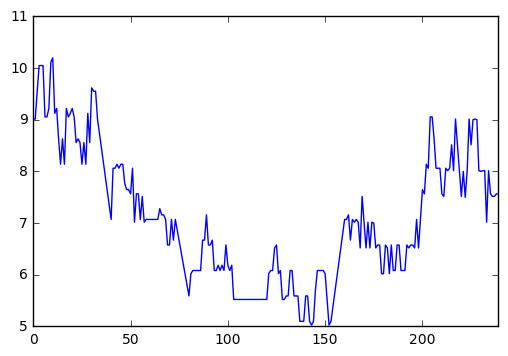

In [18]:
df.z.plot()

In [170]:
df.to_csv("testOutputNotNormalizedIncludingZ.csv")

In [115]:
df.describe()

,address,lx,ly,z,rx,ry
count,240.00000,240.000000,240.000000,240.000000,240.000000,240.000000
mean,119.50000,316.879167,167.039583,32.830189,284.060417,166.347917
std,69.42622,199.255838,75.130009,13.278500,190.007155,74.848528
min,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,59.75000,150.625000,149.500000,35.032128,115.500000,148.750000
50%,119.50000,306.750000,183.500000,38.013156,268.000000,182.500000
75%,179.25000,490.875000,214.625000,39.503164,452.250000,213.625000
max,239.00000,630.500000,258.500000,41.512046,591.000000,258.500000


In [19]:
# Normalize entire data frame
x = df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
ndf = pd.DataFrame(x_scaled, columns=["address", "x", "y", "z", "discardX", "discardY"])

In [173]:
# At this point, the address has been 'normalized' as well. 
# We don't want that

240

In [20]:
# Discard extra x, y coord (from Right channel CSV)
ndf = ndf[["address", "x", "y", "z"]]

In [21]:
# Reset the addresses to integers (not normalized)
ndf.address = df.address

In [22]:
ndf.tail()

,address,x,y,z
202,202.0,0.863465,0.406504,0.491279
203,203.0,0.866290,0.524390,0.481667
204,204.0,0.869115,0.642276,0.481667
205,205.0,0.871940,0.756098,0.491279
206,206.0,0.874765,0.878049,0.491279


In [177]:
# Filter out zero values
ndf = ndf[ndf.x+ndf.y+ndf.z > 0.0]
print len(ndf)

95


In [178]:
# invert z axis
ndf.z = 1.0-ndf.z

In [23]:
# Export normalized CSV
ndf.to_csv("future_angle_no_zeros.csv", index=False)

# Fit the data to a curve

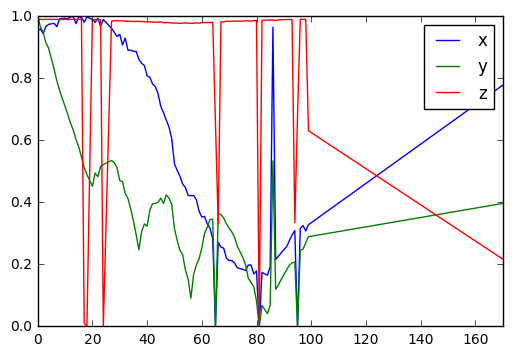

In [181]:
ndf[["x", "y", "z"]].plot()

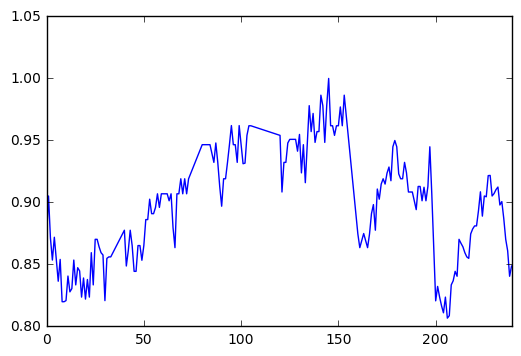

In [155]:
ndf.z.plot()

In [151]:
xyFit = np.polyfit(ndf.x, ndf.y, 30)

/Users/alpha/anaconda/lib/python2.7/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)


In [152]:
type(xyFit)

numpy.ndarray

In [153]:
dfFit = pd.DataFrame(xyFit)

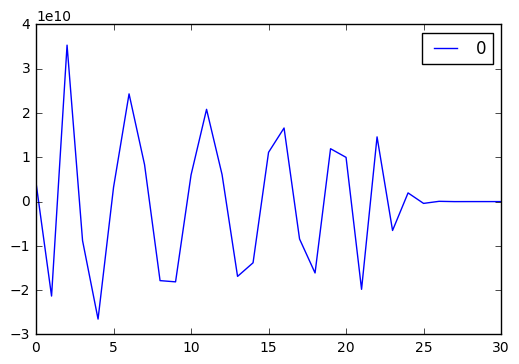

In [154]:
dfFit.plot()